In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [2]:
# Error-maximizing noise (class targeted)
pgd_10 = '/vulcanscratch/psando/untrainable_datasets/adv_poisons/targeted'
pgd_250 = '/vulcanscratch/psando/untrainable_datasets/adv_poisons/targeted_resnet18_iter=250'

fc_pgd_250 = '/vulcanscratch/psando/untrainable_datasets/adv_poisons/fresh_craft/targeted_ResNet18_iter=250'
fc_mifgsm_10 = '/vulcanscratch/psando/untrainable_datasets/adv_poisons/fresh_craft/targeted_ResNet18_optim=MIFGSM_iter=10_paugment'

poison_paths = [pgd_10, pgd_250, fc_pgd_250, fc_mifgsm_10]

In [3]:
transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

class CIFAR_load(torch.utils.data.Dataset):
    def __init__(self, root, baseset):

        self.baseset = baseset
        self.transform = self.baseset.transform
        self.samples = os.listdir(os.path.join(root, 'data'))
        self.root = root

    def __len__(self):
        return len(self.baseset)

    def __getitem__(self, idx):
        true_index = int(self.samples[idx].split('.')[0])
        true_img, label = self.baseset[true_index]
        return self.transform(Image.open(os.path.join(self.root, 'data',
                                            self.samples[idx]))), label, true_img

In [4]:
dm = torch.tensor([0.4914, 0.4822, 0.4465])[None, :, None, None]
ds = torch.tensor([0.2023, 0.1994, 0.2010])[None, :, None, None]

norm: tensor(0.0314)
label: 1


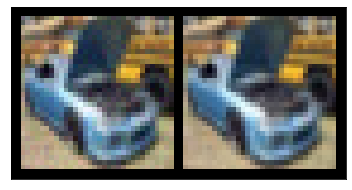

In [5]:
# Test first poison path
poison_path = poison_paths[0]
baseset = torchvision.datasets.CIFAR10(root='/vulcanscratch/psando/cifar-10', train=True, download=False, transform=transform_test)
trainset = CIFAR_load(root=poison_path, baseset=baseset)

# unnormalize x_adv and x
# delta = x_adv - x
x_adv = trainset[0][0].unsqueeze(dim=0) * ds + dm
x = trainset[0][2].unsqueeze(dim=0) * ds + dm

show(make_grid(torch.cat([x_adv, x], dim=0)))

delta = x_adv - x

print('norm:',torch.norm(delta, p=np.inf))
print('label:',trainset[0][1])

In [6]:
def get_classwise_deltas(poison_path, num_classes=10):
    deltas = {}
    for i in range(num_classes):
        deltas[i] = []
    
    # Create poison dataset
    baseset = torchvision.datasets.CIFAR10(root='/vulcanscratch/psando/cifar-10', train=True, download=False, transform=transform_test)
    trainset = CIFAR_load(root=poison_path, baseset=baseset)
    
    # Iterate through poison
    for idx, batch in tqdm(enumerate(trainset), desc='Loading Deltas'):
        im_adv, label, im = batch
        
        # Unnormalize and compute delta
        x_adv = im_adv.unsqueeze(dim=0) * ds + dm
        x = im.unsqueeze(dim=0) * ds + dm
        delta = x_adv - x
                
        deltas[label].append(delta)
    
    # Concatenate lists along dim=0 into a single tensor 
    for k in deltas.keys():
        l = deltas[k]
        deltas[k] = torch.cat(l, dim=0)
            
    return deltas

deltas = get_classwise_deltas(poison_paths[0])

Loading Deltas: 50000it [04:47, 174.08it/s]


In [21]:
def pc_deltas(deltas):
    """Computes the principal components of class-wise deltas
       Returns covariances
    """
    # Delta tensors of shape (N, 3, 32, 32)
    # Reshape to (N, 3*32*32)
    for k in deltas.keys():
        size = len(deltas[k])
        deltas[k] = deltas[k].reshape(size, -1)
        assert size == 5000, 'Every CIFAR-10 class has 5000 samples, so there should be 5000 deltas.'
    
    cov_dict = {}
    for k in deltas.keys():
        usv = torch.pca_lowrank(deltas[k], q=100, center=True, niter=20)
        
        S = usv[1]
        cov = S ** 2 / (len(deltas[k]) - 1)
        #print(f'==> Cov PC targeted deltas ({k} -> {(k+1)%10}): {cov}') 
        #print(f'sum {torch.sum(cov).item()}')
        cov_dict[k] = cov
    return cov_dict

In [64]:
#
# Cleanup
# 

# Error-maximizing noise (class targeted)
poison_names = [
'rotation_ResNet50_optim=PGD_iter=10',
'rotation_ResNet50_optim=PGD_iter=100_slurmid=979326',
'rotation_ResNet50_optim=PGD_iter=10_slurmid=978428',
'rotation_ResNet50_optim=PGD_iter=10_slurmid=979437',
'rotation_ResNet50_optim=PGD_iter=200',
'rotation_ResNet50_optim=PGD_iter=200_slurmid=978429',
'targeted_random_ResNet18_iter=250',
'targeted_ResNet18_iter=250',
'targeted_ResNet18_optim=MIFGSM_iter=10',
'targeted_ResNet18_optim=MIFGSM_iter=10_paugment',
'targeted_ResNet18_optim=MIFGSM_iter=20',
'targeted_ResNet18_optim=MIFGSM_nesterov_iter=10_paugment',
'targeted_ResNet50_iter=50',
]
poison_dir = '/vulcanscratch/psando/untrainable_datasets/adv_poisons/fresh_craft'
poison_paths = [os.path.join(poison_dir, x) for x in poison_names]
poison_accs = [71.826, 79.74, 79.97, 72.80, 79.96, 79.72, 76.836, 8.484, 24.63, 14.752, 25.64, 16.246, 10.91]

In [65]:
# poison_paths = [pgd_10, pgd_250, fc_pgd_250, fc_mifgsm_10]
# poison_accs = [74.73, 16.86, 8.48, 14.75]
covariances = []
for poison_path in poison_paths:
    print(f'Poison: {poison_path}')
    deltas = get_classwise_deltas(poison_path)
    cov_dict = pc_deltas(deltas)
    covariances.append(cov_dict)

Poison: /vulcanscratch/psando/untrainable_datasets/adv_poisons/fresh_craft/rotation_ResNet50_optim=PGD_iter=10


Loading Deltas: 50000it [01:35, 525.32it/s]


Poison: /vulcanscratch/psando/untrainable_datasets/adv_poisons/fresh_craft/rotation_ResNet50_optim=PGD_iter=100_slurmid=979326


Loading Deltas: 50000it [05:56, 140.41it/s]


Poison: /vulcanscratch/psando/untrainable_datasets/adv_poisons/fresh_craft/rotation_ResNet50_optim=PGD_iter=10_slurmid=978428


Loading Deltas: 50000it [02:45, 302.04it/s]


Poison: /vulcanscratch/psando/untrainable_datasets/adv_poisons/fresh_craft/rotation_ResNet50_optim=PGD_iter=10_slurmid=979437


Loading Deltas: 50000it [07:38, 109.12it/s]


Poison: /vulcanscratch/psando/untrainable_datasets/adv_poisons/fresh_craft/rotation_ResNet50_optim=PGD_iter=200


Loading Deltas: 50000it [01:56, 428.44it/s]


Poison: /vulcanscratch/psando/untrainable_datasets/adv_poisons/fresh_craft/rotation_ResNet50_optim=PGD_iter=200_slurmid=978429


Loading Deltas: 50000it [03:49, 217.83it/s]


Poison: /vulcanscratch/psando/untrainable_datasets/adv_poisons/fresh_craft/targeted_random_ResNet18_iter=250


Loading Deltas: 50000it [01:58, 421.41it/s]


Poison: /vulcanscratch/psando/untrainable_datasets/adv_poisons/fresh_craft/targeted_ResNet18_iter=250


Loading Deltas: 50000it [01:56, 428.47it/s]


Poison: /vulcanscratch/psando/untrainable_datasets/adv_poisons/fresh_craft/targeted_ResNet18_optim=MIFGSM_iter=10


Loading Deltas: 50000it [08:38, 96.49it/s] 


Poison: /vulcanscratch/psando/untrainable_datasets/adv_poisons/fresh_craft/targeted_ResNet18_optim=MIFGSM_iter=10_paugment


Loading Deltas: 50000it [02:20, 355.16it/s]


Poison: /vulcanscratch/psando/untrainable_datasets/adv_poisons/fresh_craft/targeted_ResNet18_optim=MIFGSM_iter=20


Loading Deltas: 50000it [05:23, 154.54it/s]


Poison: /vulcanscratch/psando/untrainable_datasets/adv_poisons/fresh_craft/targeted_ResNet18_optim=MIFGSM_nesterov_iter=10_paugment


Loading Deltas: 50000it [07:54, 105.36it/s]


Poison: /vulcanscratch/psando/untrainable_datasets/adv_poisons/fresh_craft/targeted_ResNet50_iter=50


Loading Deltas: 50000it [06:01, 138.24it/s]


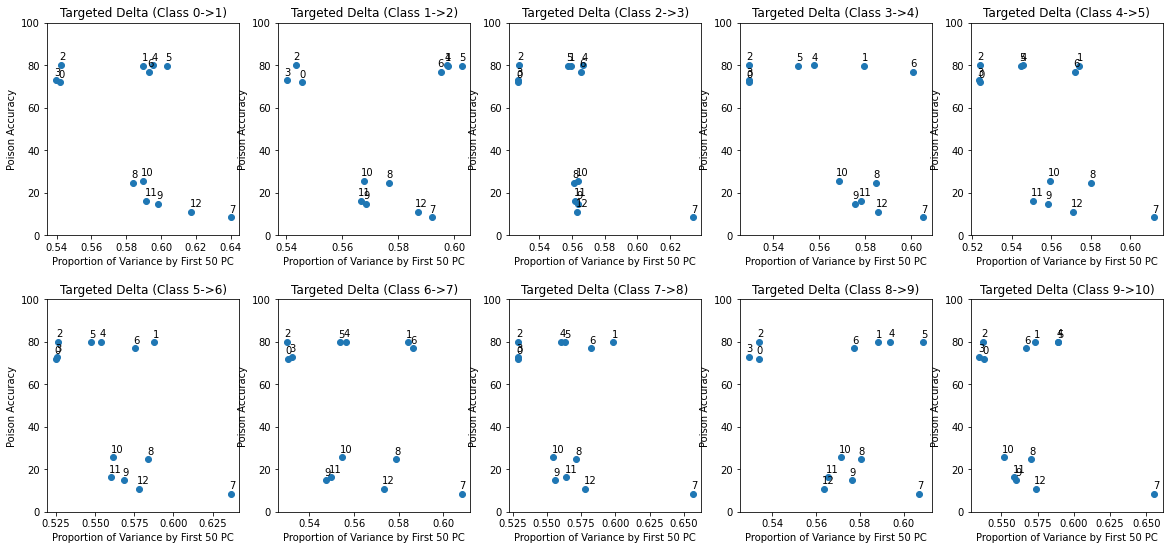

In [106]:
def plot_scatter(k, poison_accs, covariances):
    fig, axs = plt.subplots(2, 5, figsize=(20,9))
    fig.subplots_adjust(hspace=0.3)
    subplot_idx = [(0,0), (0,1), (0,2), (0,3), (0,4), (1,0), (1,1), (1,2), (1,3), (1,4)]
    
    for i in range(10):
        variance_proportion = []
        for cov_dict in covariances:
            # normalize
            cov = cov_dict[i]
            s = torch.sum(cov)
            cov = cov / s
            proportion_in_top_k = torch.sum(cov[:k]).item()
            variance_proportion.append(proportion_in_top_k)
        
        axs[subplot_idx[i]].scatter(x=variance_proportion, y=poison_accs)
        for j, txt in enumerate(range(len(poison_accs))):
            axs[subplot_idx[i]].annotate(txt, (variance_proportion[j]-0.001, poison_accs[j]+2.5))
        axs[subplot_idx[i]].set_title(f'Targeted Delta (Class {i}->{i+1%10})')
        axs[subplot_idx[i]].set_xlabel(f"Proportion of Variance by First {k} PC")
        axs[subplot_idx[i]].set_ylabel("Poison Accuracy")
        axs[subplot_idx[i]].set_ybound(0,100)
    
plot_scatter(k=50, poison_accs=poison_accs, covariances=covariances)

In [58]:
for poison_path in poison_paths:
    print(f'Poison: {poison_path}')
    deltas = get_classwise_deltas(poison_path)
    pc_deltas(deltas)

Poison: /vulcanscratch/psando/untrainable_datasets/adv_poisons/targeted
0
10000
20000
30000
40000
==> Covariance of principal components for class (0 -> 1): tensor([0.0056, 0.0016, 0.0015, 0.0015, 0.0015, 0.0014])
==> Covariance of principal components for class (1 -> 2): tensor([0.0059, 0.0016, 0.0015, 0.0015, 0.0015, 0.0015])
==> Covariance of principal components for class (2 -> 3): tensor([0.0028, 0.0015, 0.0015, 0.0015, 0.0015, 0.0014])
==> Covariance of principal components for class (3 -> 4): tensor([0.0035, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015])
==> Covariance of principal components for class (4 -> 5): tensor([0.0019, 0.0015, 0.0015, 0.0015, 0.0014, 0.0014])
==> Covariance of principal components for class (5 -> 6): tensor([0.0024, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015])
==> Covariance of principal components for class (6 -> 7): tensor([0.0036, 0.0015, 0.0015, 0.0015, 0.0014, 0.0014])
==> Covariance of principal components for class (7 -> 8): tensor([0.0034, 0.0015, 0.0015,